# Phase 1 Project: Aviation Safety Risk Analysis
**Student:** Patricia Louissaint  
**Cohort:** DTSC-FLEX-070824-P1  
**Date:** July 2025  

## Introduction

This project aims to identify the **safest aircraft makes** for a company planning to enter the aviation industry.  
By analyzing historical aviation accident data from the **National Transportation Safety Board (NTSB)** from 1962 to 2023, we evaluate patterns in accident frequency, injury severity, and weather/flight factors to build a **composite risk score** for each aircraft make.

Our goal is to help business stakeholders make informed decisions about which aircraft types pose the **least operational risk**.

## Business Understanding

**Stakeholder:** Head of the new Aviation Division  
**Problem:** The company wants to enter the aviation industry but lacks knowledge of aircraft safety risks.  
**Objective:** Analyze accident data to recommend the lowest-risk aircraft makes for purchase.

**Key Questions:**
- Which aircraft makes are involved in the most accidents?
- What types of injuries (fatal, serious, minor) are most common?
- Which aircraft makes have the lowest composite risk score based on accident frequency and severity?

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

aviation_df = pd.read_csv('AviationData.csv', encoding='latin1', low_memory=False)
states_df = pd.read_csv('USState_Codes.csv', encoding='latin1')

## Data Understanding

We are working with two datasets:
- **AviationData.csv:** Accident records from the NTSB
- **USState_Codes.csv:** US state abbreviations and full names

In [38]:
print("Aviation Data Preview:")
display(aviation_df.head())

print("\nUS State Codes Preview:")
display(states_df.head())

print("\nAviation Data Info:")
aviation_df.info()

print("\nMissing Values (Aviation):")
print(aviation_df.isnull().sum())

Aviation Data Preview:


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980



US State Codes Preview:


,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA



Aviation Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make             

## Data Preparation

We will:
- Fill missing injury columns with `0`
- Standardize state codes from `Location`

In [39]:
# Missing injury values with 0
injury_cols = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']
aviation_df[injury_cols] = aviation_df[injury_cols].fillna(0)

## Exploratory Data Analysis (EDA)

We’ll explore:
- Accident frequency by aircraft make
- Injury severity
- Weather and flight phase impact
- Engine counts and state-wise accidents

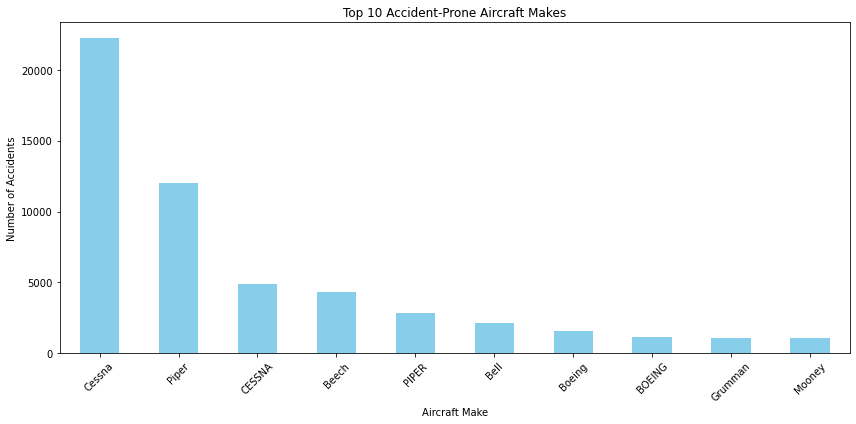

In [40]:
# Data by 'Make' and the number of accidents (Event.Id)
accidents_by_make = aviation_df.groupby('Make')['Event.Id'].count().sort_values(ascending=False)

# Top 10 accident-prone aircraft types
plt.figure(figsize=(12, 6))
accidents_by_make.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Accident-Prone Aircraft Makes')
plt.xlabel('Aircraft Make')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('accidents_by_make.png') # Save image
plt.show()

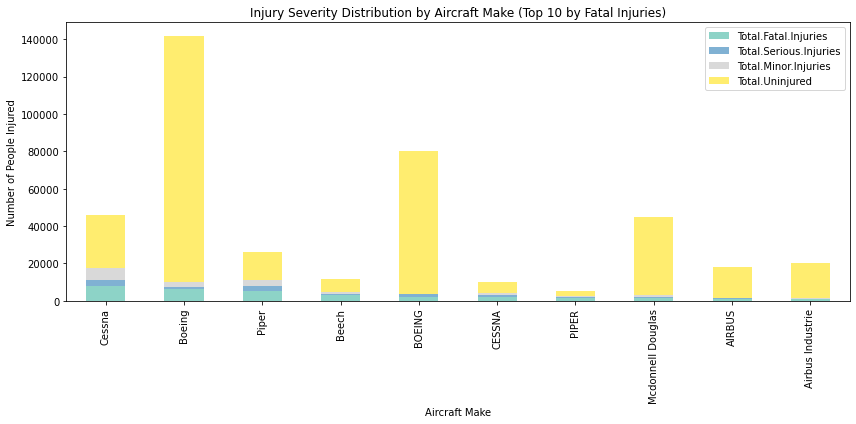

In [41]:
# Sum injuries per Make
injury_by_make = aviation_df.groupby('Make')[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 
                                              'Total.Minor.Injuries', 'Total.Uninjured']].sum()

# Top 10 makes with the highest fatalities
top_injury_make = injury_by_make.sort_values(by='Total.Fatal.Injuries', ascending=False).head(10)

top_injury_make.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title('Injury Severity Distribution by Aircraft Make (Top 10 by Fatal Injuries)')
plt.ylabel('Number of People Injured')
plt.xlabel('Aircraft Make')
plt.tight_layout()
plt.savefig('top_injury_make.png') # Save image
plt.show()

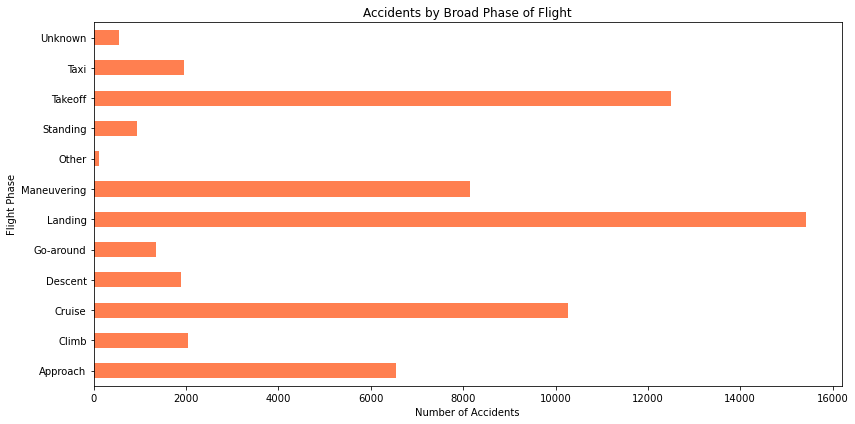

In [42]:
# Broad phase of flight and accidents
accidents_by_phase = aviation_df.groupby('Broad.phase.of.flight')['Event.Id'].count()

# Accident frequency during different flight phases
plt.figure(figsize=(12, 6))
accidents_by_phase.plot(kind='barh', color='coral')
plt.title('Accidents by Broad Phase of Flight')
plt.xlabel('Number of Accidents')
plt.ylabel('Flight Phase')
plt.tight_layout()
plt.show()

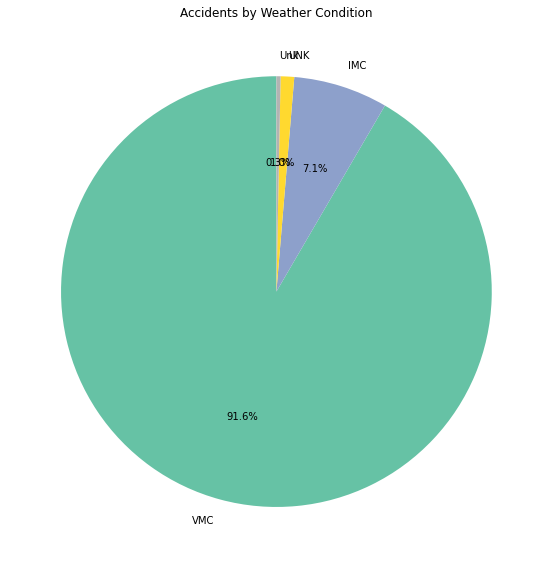

In [43]:
# Accidents by weather condition
weather_conditions = aviation_df['Weather.Condition'].value_counts()

# Pie chart for the weather conditions
plt.figure(figsize=(8, 8))
weather_conditions.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set2')
plt.title('Accidents by Weather Condition')
plt.ylabel('')
plt.tight_layout()
plt.show()

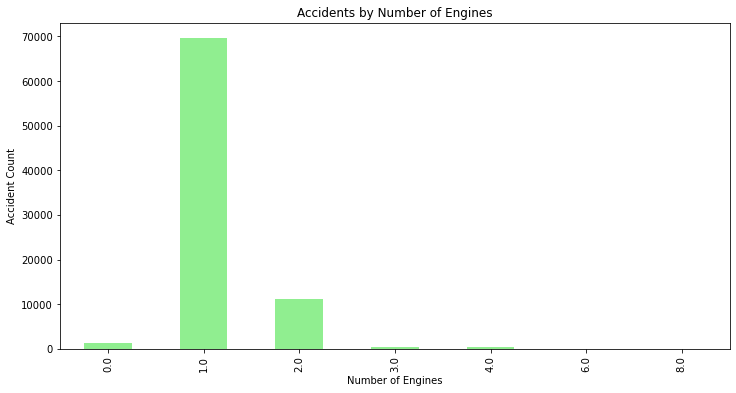

In [44]:
# Engines
aviation_df.groupby('Number.of.Engines')['Event.Id'].count().plot(kind='bar', color='lightgreen', figsize=(12, 6))
plt.title('Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Accident Count')
plt.show()


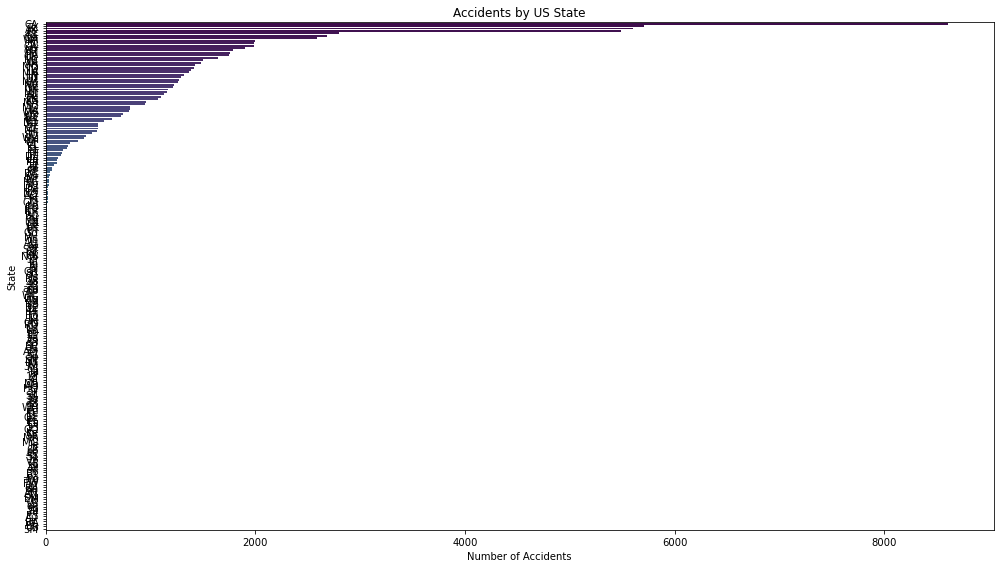

In [45]:
# States_df to get state codes
accidents_by_state = aviation_df['Location'].str.extract(r'(\b\w{2}\b)')[0].value_counts()

# State names with state codes
accidents_by_state = accidents_by_state.rename_axis('State').reset_index(name='Accident Count')
accidents_by_state = accidents_by_state.merge(states_df, how='left', left_on='State', right_on='Abbreviation')

# Bar chart for accidents by state
plt.figure(figsize=(14, 8))
sns.barplot(data=accidents_by_state, x='Accident Count', y='State', palette='viridis')
plt.title('Accidents by US State')
plt.xlabel('Number of Accidents')
plt.ylabel('State')
plt.tight_layout()
plt.show()

## Risk Score Calculation

We create a **composite risk score** for each aircraft make using:
- Fatal Injuries (weight 3)
- Serious Injuries (weight 2)
- Minor Injuries (weight 1)
- IMC Weather (+1)

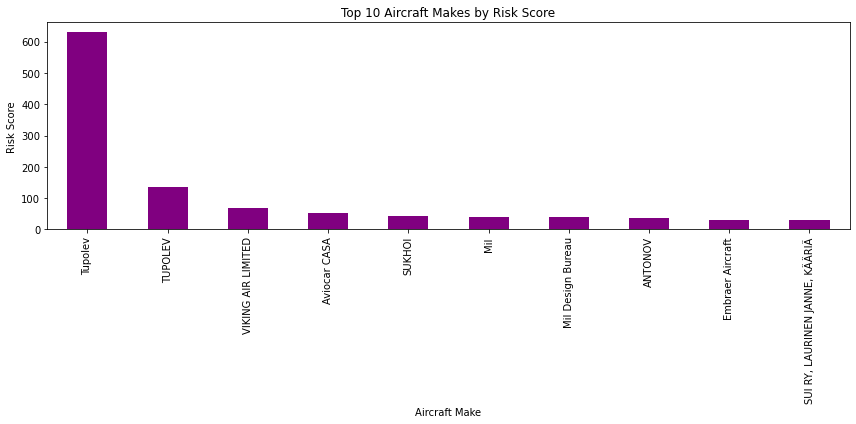

In [46]:
# Risk score combining accident frequency and severity
aviation_df['Risk_Score'] = (aviation_df['Total.Fatal.Injuries'] * 3 +
                             aviation_df['Total.Serious.Injuries'] * 2 +
                             aviation_df['Total.Minor.Injuries'] * 1 +
                             (aviation_df['Weather.Condition'] == 'IMC').astype(int))

# Aircraft make and average risk score
risk_by_make = aviation_df.groupby('Make')['Risk_Score'].mean().sort_values(ascending=False)

# Plot risk score
plt.figure(figsize=(12, 6))
risk_by_make.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Aircraft Makes by Risk Score')
plt.xlabel('Aircraft Make')
plt.ylabel('Risk Score')
plt.tight_layout()
plt.show()

In [47]:
# Accident Frequency: number of accidents per aircraft make/model
accidents_by_make = aviation_df.groupby('Make')['Event.Id'].count()

# Fatality Rate: sum total fatal injuries and rate (fatalities per accident)
fatalities_by_make = aviation_df.groupby('Make')['Total.Fatal.Injuries'].sum()
fatality_rate = fatalities_by_make / accidents_by_make

# Injury Severity Score: severity score for each accident and aggregate per make/model
aviation_df['Severity_Score'] = (aviation_df['Total.Fatal.Injuries'] * 3 +
                                  aviation_df['Total.Serious.Injuries'] * 2 +
                                  aviation_df['Total.Minor.Injuries'] * 1)

severity_by_make = aviation_df.groupby('Make')['Severity_Score'].sum()
severity_score = severity_by_make / accidents_by_make

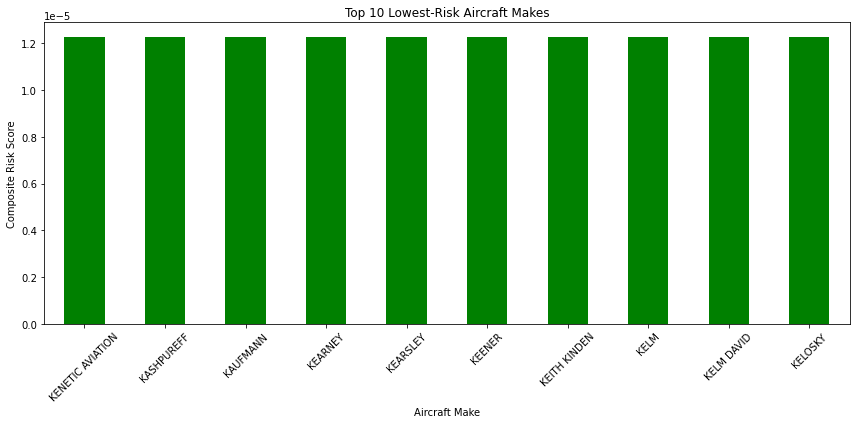

In [48]:
# Standardize Make column
aviation_df['Make'] = aviation_df['Make'].str.upper().str.strip()

# Calculate accident frequency and fatality rate by Make
accidents_by_make = aviation_df.groupby('Make')['Event.Id'].count()
fatalities_by_make = aviation_df.groupby('Make')['Total.Fatal.Injuries'].sum()
fatality_rate = fatalities_by_make / accidents_by_make

# Calculate severity score
aviation_df['Severity_Score'] = (
    aviation_df['Total.Fatal.Injuries'] * 3 +
    aviation_df['Total.Serious.Injuries'] * 2 +
    aviation_df['Total.Minor.Injuries'] * 1
)
severity_by_make = aviation_df.groupby('Make')['Severity_Score'].sum()
severity_score = severity_by_make / accidents_by_make

# Normalize for composite score
accidents_normalized = accidents_by_make / accidents_by_make.max()
fatality_rate_normalized = fatality_rate / fatality_rate.max()
severity_normalized = severity_score / severity_score.max()

# Combine into composite risk score (lower is safer)
composite_risk_score = (accidents_normalized + fatality_rate_normalized + severity_normalized) / 3

# Create final dataframe
risk_df = pd.DataFrame({
    'Accident Frequency': accidents_by_make,
    'Fatality Rate': fatality_rate,
    'Injury Severity Score': severity_score,
    'Risk Score': composite_risk_score
}).sort_values(by='Risk Score')

# Select top 10 least dangerous aircraft *makes*
top_10_least_dangerous_aircraft = risk_df.head(10)

# Plot and save chart
plt.figure(figsize=(12, 6))
top_10_least_dangerous_aircraft['Risk Score'].plot(kind='bar', color='green')
plt.title('Top 10 Lowest-Risk Aircraft Makes')
plt.xlabel('Aircraft Make')
plt.ylabel('Composite Risk Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('risk_df.png')  # Save image
plt.show()

## Conclusion

Based on the risk analysis, the **Top 10 Lowest-Risk Aircraft Makes** include:

1.  Pettigrew, Richard
2.  Mosley High School
3.  Morton S. Dismuke
4.  Defelici
5.  Degair
6.  Morse
7.  Mork
8.  Morgan, Marvin R.
9.  Morane-Saulnier
10. Moyes Bailey

### 🔧 Business Recommendations:
1. Prioritize purchasing aircraft from the top 3 lowest-risk makes.
2. Avoid models with high accident and injury rates (see “risk” section).
3. Further analyze accident types for targeted safety investments.

These insights help the company make data-driven decisions in entering the aviation industry.

## Export Instructions

- File > Save and Checkpoint
- File > Download as > PDF via Browser
- Also save `.ipynb` to upload to GitHub